In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances

# === STRUCTURAL VALIDATION ===
C1p_C1p_min = 3.0
C1p_C1p_max = 6.0
angle_tolerance_deg = 30

def compute_bond_lengths(coords):
    return np.linalg.norm(coords[1:] - coords[:-1], axis=1)

def compute_bond_angles(coords):
    v1 = coords[1:-1] - coords[:-2]
    v2 = coords[2:] - coords[1:-1]
    dot_prod = np.sum(v1 * v2, axis=1)
    norms = np.linalg.norm(v1, axis=1) * np.linalg.norm(v2, axis=1)
    cos_theta = np.clip(dot_prod / norms, -1.0, 1.0)
    return np.degrees(np.arccos(cos_theta))

def validate_structure(coords):
    bond_lengths = compute_bond_lengths(coords)
    bond_angles = compute_bond_angles(coords)
    length_violations = np.sum((bond_lengths < C1p_C1p_min) | (bond_lengths > C1p_C1p_max))
    angle_violations = np.sum((bond_angles < (180 - angle_tolerance_deg)) | 
                              (bond_angles > (180 + angle_tolerance_deg)))
    return {
        "num_length_violations": int(length_violations),
        "num_angle_violations": int(angle_violations),
        "mean_bond_length": float(np.mean(bond_lengths)),
        "mean_bond_angle": float(np.mean(bond_angles)),
    }

def validate_all_structures(submissions):
    results = []
    for sub_idx, df in enumerate(submissions):
        for i in range(5):
            coords = df[[f"x_{i+1}", f"y_{i+1}", f"z_{i+1}"]].values
            metrics = validate_structure(coords)
            metrics["submission_idx"] = sub_idx
            metrics["structure_i"] = i
            results.append(metrics)
    return results

# === ENSEMBLE FUNCTIONS ===
def ensemble_best5_diverse(submissions, scores):
    meta_cols = ['ID', 'resname', 'resid']
    all_structures = []
    structure_sources = []
    for s_idx, df in enumerate(submissions):
        for i in range(5):
            coords = df[[f"x_{i+1}", f"y_{i+1}", f"z_{i+1}"]].values
            all_structures.append(coords)
            structure_sources.append((s_idx, i))
    flat_structures = [s.reshape(-1) for s in all_structures]
    D = pairwise_distances(flat_structures, metric='euclidean')
    best_submission_idx = np.argmax(scores)
    first_structure_idx = structure_sources.index((best_submission_idx, 0))
    selected_idx = [first_structure_idx]
    while len(selected_idx) < 5:
        remaining = list(set(range(len(all_structures))) - set(selected_idx))
        next_idx = max(remaining, key=lambda i: min(D[i, j] for j in selected_idx))
        selected_idx.append(next_idx)
    selected = [all_structures[i] for i in selected_idx]
    output = submissions[0][meta_cols].copy()
    for i in range(5):
        output[f"x_{i+1}"] = selected[i][:, 0]
        output[f"y_{i+1}"] = selected[i][:, 1]
        output[f"z_{i+1}"] = selected[i][:, 2]
    return output

def ensemble_weighted_average(submissions, scores):
    meta_cols = ['ID', 'resname', 'resid']
    num_structures = 5
    weights = np.array(scores)
    weights = weights / np.sum(weights)
    pred_stack = []
    for df in submissions:
        pred_coords = []
        for i in range(num_structures):
            pred_coords.append(df[[f"x_{i+1}", f"y_{i+1}", f"z_{i+1}"]].values)
        pred_coords = np.stack(pred_coords, axis=1)
        pred_stack.append(pred_coords)
    pred_stack = np.stack(pred_stack, axis=0)
    weighted_avg = np.tensordot(weights, pred_stack, axes=([0], [0]))
    output = submissions[0][meta_cols].copy()
    for i in range(num_structures):
        output[f"x_{i+1}"] = weighted_avg[:, i, 0]
        output[f"y_{i+1}"] = weighted_avg[:, i, 1]
        output[f"z_{i+1}"] = weighted_avg[:, i, 2]
    return output

# === LOAD FILES AND RUN ===
folder = "/kaggle/input/stanford-rna-folding-best-submissions"
files = [f for f in os.listdir(folder) if f.endswith(".csv")]

def extract_score(filename):
    try:
        return float(filename.rstrip(".csv").split("_")[-1])
    except ValueError:
        return 0.0

submissions, scores = [], []
for f in files:
    df = pd.read_csv(os.path.join(folder, f))
    submissions.append(df)
    scores.append(extract_score(f))

# Run both ensembles
diverse_ensemble = ensemble_best5_diverse(submissions, scores)
weighted_ensemble = ensemble_weighted_average(submissions, scores)

diverse_ensemble.to_csv("submission_best5_diverse.csv", index=False)
weighted_ensemble.to_csv("submission_weighted_average.csv", index=False)

# Validate all original submissions
validation_df = pd.DataFrame(validate_all_structures(submissions))
validation_df.to_csv("structure_validation_metrics.csv", index=False)

print("✅ Done: 2 ensemble submissions saved, validation CSV created.")


✅ Done: 2 ensemble submissions saved, validation CSV created.


/tmp/ipykernel_13/3702263172.py:19: RuntimeWarning: invalid value encountered in divide
  cos_theta = np.clip(dot_prod / norms, -1.0, 1.0)
/tmp/ipykernel_13/3702263172.py:20: RuntimeWarning: invalid value encountered in arccos
  return np.degrees(np.arccos(cos_theta))
/tmp/ipykernel_13/3702263172.py:26: RuntimeWarning: invalid value encountered in less
  angle_violations = np.sum((bond_angles < (180 - angle_tolerance_deg)) |
/tmp/ipykernel_13/3702263172.py:27: RuntimeWarning: invalid value encountered in greater
  (bond_angles > (180 + angle_tolerance_deg)))
/tmp/ipykernel_13/3702263172.py:19: RuntimeWarning: invalid value encountered in divide
  cos_theta = np.clip(dot_prod / norms, -1.0, 1.0)
/tmp/ipykernel_13/3702263172.py:20: RuntimeWarning: invalid value encountered in arccos
  return np.degrees(np.arccos(cos_theta))
/tmp/ipykernel_13/3702263172.py:26: RuntimeWarning: invalid value encountered in less
  angle_violations = np.sum((bond_angles < (180 - angle_tolerance_deg)) |
/tmp/i

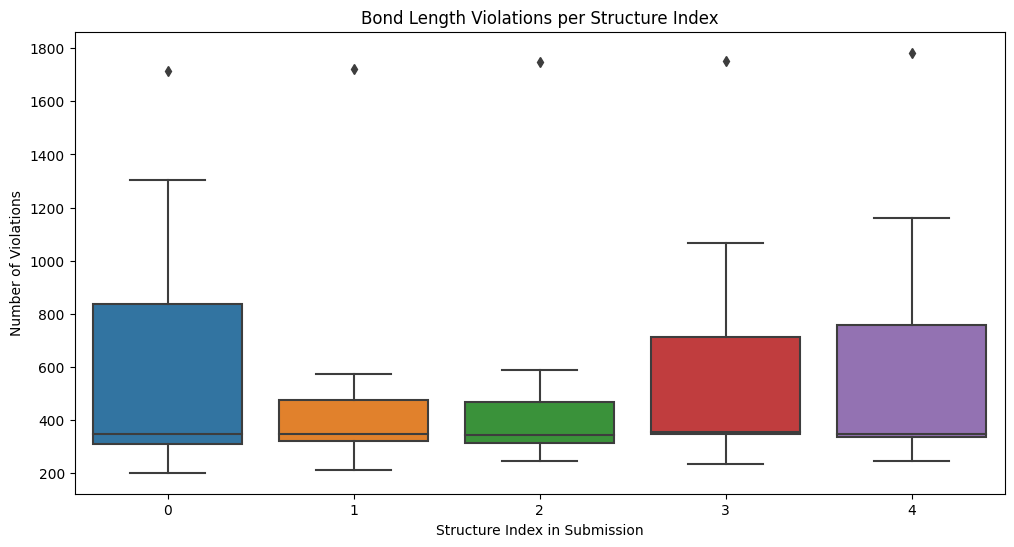

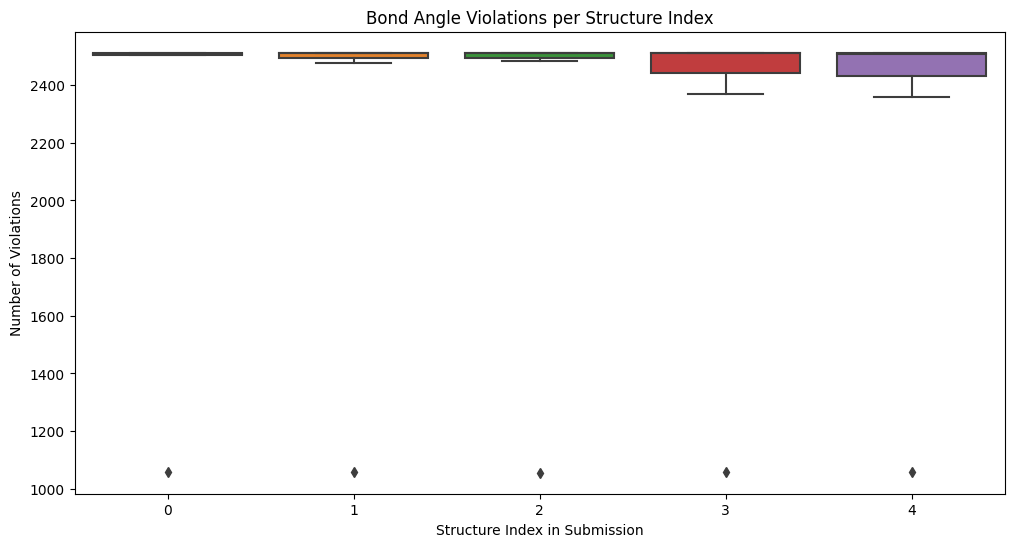

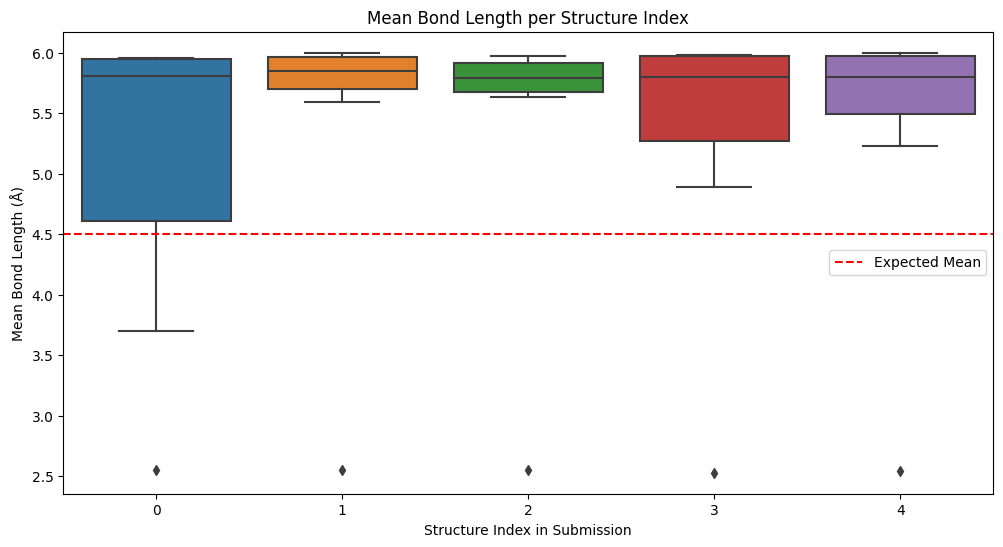

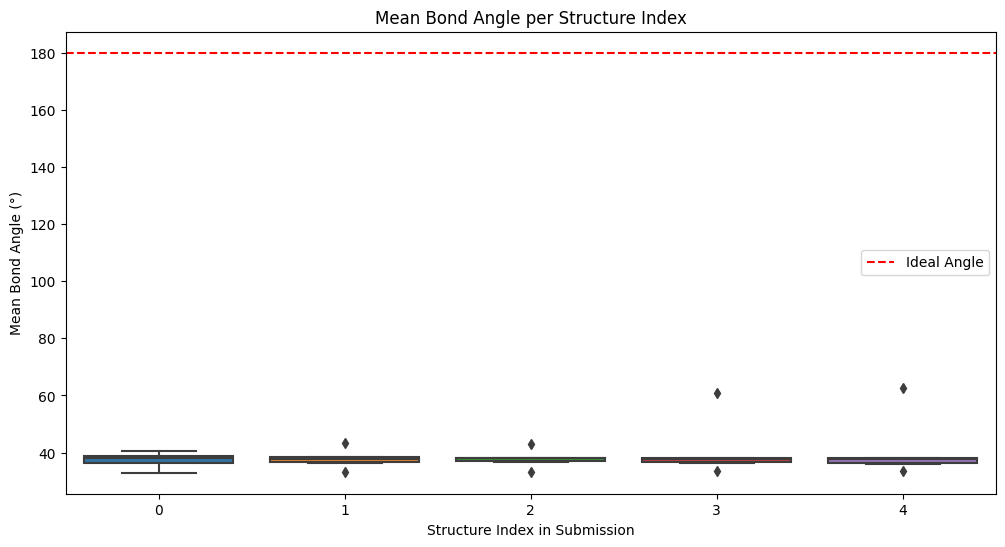

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_validation_summary(validation_df):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=validation_df, x="structure_i", y="num_length_violations")
    plt.title("Bond Length Violations per Structure Index")
    plt.xlabel("Structure Index in Submission")
    plt.ylabel("Number of Violations")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=validation_df, x="structure_i", y="num_angle_violations")
    plt.title("Bond Angle Violations per Structure Index")
    plt.xlabel("Structure Index in Submission")
    plt.ylabel("Number of Violations")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=validation_df, x="structure_i", y="mean_bond_length")
    plt.title("Mean Bond Length per Structure Index")
    plt.xlabel("Structure Index in Submission")
    plt.ylabel("Mean Bond Length (Å)")
    plt.axhline(4.5, color='red', linestyle='--', label='Expected Mean')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=validation_df, x="structure_i", y="mean_bond_angle")
    plt.title("Mean Bond Angle per Structure Index")
    plt.xlabel("Structure Index in Submission")
    plt.ylabel("Mean Bond Angle (°)")
    plt.axhline(180, color='red', linestyle='--', label='Ideal Angle')
    plt.legend()
    plt.show()

plot_validation_summary(validation_df)
